<a href="https://colab.research.google.com/github/ReAlex1902/Tweets_Classification/blob/main/bert_with_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 895 kB 55.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
## upload your kaggle.json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexdraxler","key":"591fcba6ee3bd3090df1a79f71b77413"}'}

In [3]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Loading Data

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 40.1MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 59.9MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 58.0MB/s]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

In [6]:
## Let's use GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
PATH = '/content/train.csv'
df = pd.read_csv(PATH)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df.shape, df[df['target'] == 1].shape, df[df['target'] == 0].shape

((7613, 5), (3271, 5), (4342, 5))

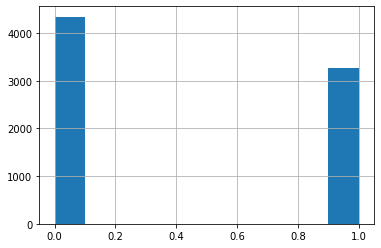

In [9]:
df['target'].hist();

In [10]:
## We will upsample our data to have 50/50 division

from sklearn.utils import resample

df_minority = df[df['target'] == 1].copy()
df_minority_upsampled = resample(df_minority, replace = True, 
                                 n_samples = df['target'].value_counts()[0], 
                                 random_state = 11)
df_minority_upsampled.shape

(4342, 5)

In [11]:
df = pd.concat([df[df['target'] == 0].copy(), df_minority_upsampled]).reset_index()
df.sample(5)

,index,id,keyword,location,text,target
3224,5539,7903,radiation%20emergency,"La Grange Park, IL",DOE's WIPP facility in NM investigating a site...,0
3061,5320,7595,pandemonium,NaN,Tube strike = absolute pandemonium,0
2254,3811,5413,first%20responders,Texas,@USATODAY. PRAYING FOR GOD'S HEALING AND SAFE...,0
1184,1907,2741,crushed,NaN,#AyekoRadio play Brasswork Agency - Crushed an...,0
920,1473,2122,catastrophe,"New Brunswick, NJ",God bless catastrophe,0


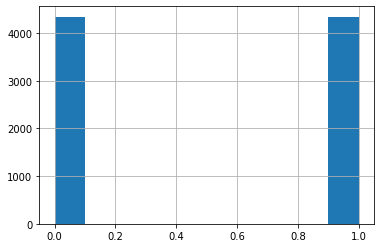

In [12]:
df['target'].hist();

# Tokenization

In [13]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case = True)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [14]:
sentence = df.loc[0, 'text']

print(sentence)
print(tokenizer.tokenize(sentence))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

What's up man?
['what', "'", 's', 'up', 'man', '?']
[1184, 112, 188, 1146, 1299, 136]


In [15]:
print(tokenizer.encode(sentence))

[101, 1184, 112, 188, 1146, 1299, 136, 102]


In [16]:
print(tokenizer.encode_plus(sentence))

{'input_ids': [101, 1184, 112, 188, 1146, 1299, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation, digits

nltk.download('stopwords')

def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence, ):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    # sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    # sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    # sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    # tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # remove_digits = str.maketrans('', '', digits)
    # tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    tokens = tokens.replace("â", "")
    tokens = tokens.replace("@", "")
    tokens = tokens.replace("#", "")
    tokens = tokens.replace("$", "")
    return tokens

df['text'] = df['text'].apply(clean_sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
df.sample(10)

,index,id,keyword,location,text,target
5480,5618,8016,refugees,paradise,retweet cameroon repatriating 1200 nigerian re...,1
4051,6998,10035,twister,"Plano,TX",briannafrost twister bill paxton helen hunt!,0
6586,7339,10506,wildfire,NaN,wildfire burns california u.s. china economic ...,1
2100,3529,5044,eyewitness,NaN,dk eyewitness travel guide: denmark: travel gu...,0
1267,2038,2925,danger,World,permits bear hunting danger outnumbering actua...,0
3632,6214,8865,smoke,NaN,sammysosita smoke blunt &amp; get it.. ciggs you.,0
2967,5128,7315,nuclear%20reactor,Anywhere I like,government pressure abandon plans construct uk...,0
2582,4448,6330,hostage,"Victorville, CA",wut lonely lunch. got ditched. i'm hungrier ho...,0
3568,6138,8757,siren,Paris.,? nowplaying song siren john frusciante (2009),0
3643,6227,8888,smoke,Indonesia,teamatowinner no.. mean mino said smoke? u men...,0


In [19]:
## some key constants

class Config:
    batch_size = 32
    max_len = 0

In [20]:
## Finding the maximum length of the sentence

Config.max_len = 0

for sent in df.loc[:, 'text']:
    sent = tokenizer.encode(sent, add_special_tokens = True)
    Config.max_len = max(Config.max_len, len(sent))

Config.max_len

71

In [21]:
## Creating torch tensors with input IDs and attention masks

input_ids = torch.tensor([])
attention_masks = torch.tensor([])

for sent in df.loc[:, 'text']:
    encoded_sent = tokenizer.encode_plus(sent, add_special_tokens = True,
                                         max_length = Config.max_len, padding = 'max_length',
                                         return_tensors = 'pt')
    input_ids = torch.cat([input_ids, encoded_sent['input_ids']])
    attention_masks = torch.cat([attention_masks, encoded_sent['attention_mask']])

In [22]:
input_ids

tensor([[  101.,  1184.,   112.,  ...,     0.,     0.,     0.],
        [  101.,  1567., 11669.,  ...,     0.,     0.,     0.],
        [  101.,  2247.,  9020.,  ...,     0.,     0.,     0.],
        ...,
        [  101.,  9605.,  4680.,  ...,     0.,     0.,     0.],
        [  101.,  2824.,  3871.,  ...,     0.,     0.,     0.],
        [  101., 20454.,  2737.,  ...,     0.,     0.,     0.]])

In [23]:
attention_masks

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [24]:
labels = torch.tensor(df['target'])
labels

tensor([0, 0, 0,  ..., 1, 1, 1])

In [29]:
len(input_ids), len(attention_masks), len(labels)

(8684, 8684, 8684)

In [32]:
input_ids

tensor([[  101.,  1184.,   112.,  ...,     0.,     0.,     0.],
        [  101.,  1567., 11669.,  ...,     0.,     0.,     0.],
        [  101.,  2247.,  9020.,  ...,     0.,     0.,     0.],
        ...,
        [  101.,  9605.,  4680.,  ...,     0.,     0.,     0.],
        [  101.,  2824.,  3871.,  ...,     0.,     0.,     0.],
        [  101., 20454.,  2737.,  ...,     0.,     0.,     0.]])

In [95]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(20, size=10, replace=False)

num = int(0.9*len(input_ids))
ids = np.array(range(len(input_ids)))
train_ids = rng.choice(ids, size = num, replace = False)
val_ids = ids[~np.isin(ids, train_ids)]

In [97]:
train_ids.shape, val_ids.shape, ids.shape

((7815,), (869,), (8684,))

In [99]:
## Creating torch dataset for training and validation

from torch.utils.data import TensorDataset, random_split

# dataset = TensorDataset(input_ids, attention_masks, labels)
# val_size = int(0.1 * len(dataset))
# train_size = len(dataset) - val_size

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset = TensorDataset(input_ids[train_ids], attention_masks[train_ids], labels[train_ids])
val_dataset = TensorDataset(input_ids[val_ids], attention_masks[val_ids], labels[val_ids])

In [100]:
len(train_dataset), len(val_dataset)

(7815, 869)

In [101]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_loader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = Config.batch_size)
val_loader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = Config.batch_size)

In [102]:
next(iter(val_loader))

[tensor([[  101.,   183.,  1183.,  ...,     0.,     0.,     0.],
         [  101.,  6675.,  1167.,  ...,     0.,     0.,     0.],
         [  101.,   185.,  1324.,  ...,     0.,     0.,     0.],
         ...,
         [  101.,  1469.,   168.,  ...,     0.,     0.,     0.],
         [  101., 11019., 20623.,  ...,     0.,     0.,     0.],
         [  101., 13280.,  2296.,  ...,     0.,     0.,     0.]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0])]

# BERT

In [107]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

bert_model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [108]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler = None):
    train_loss_history = []
    train_f1_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        train_loss_accum = 0
        correct_samples = 0
        total_samples = 0

        tp, tn, fp, fn = 0, 0, 0, 0

        for index, (sentence, attention_mask, label) in enumerate(train_loader):
            model.zero_grad()

            sentence = sentence.to(device).long()
            attention_mask = attention_mask.to(device).long()
            label = label.to(device).long()

            output = model(sentence, token_type_ids = None, attention_mask = attention_mask, labels = label)
            loss_value, logits = output[0], output[1]
            train_loss_accum += loss_value.item()

            loss_value.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            _, indices = torch.max(logits, 1)
            correct_samples += torch.sum(indices == label)
            tp += len(indices[(indices == label) & (indices == 1)])
            tn += len(indices[(indices == label) & (indices == 0)])
            fp += len(indices[(indices != label) & (indices == 1)])
            fn += len(indices[(indices != label) & (indices == 0)])
            total_samples += label.shape[0]
            
        avg_loss = train_loss_accum / index
        train_accuracy = float(correct_samples) / total_samples
        train_precision = tp / (tp + fp)
        train_recall = tp / (tp + fn)
        f1_train = (2*train_precision*train_recall) / (train_precision + train_recall)
        
        val_accuracy, f1_val = eval_model(model, val_loader)

        train_loss_history.append(avg_loss)
        train_accuracy_history.append(train_accuracy)
        train_f1_history.append(f1_train)
        val_accuracy_history.append(val_accuracy)
        val_f1_history.append(f1_val)

        print(f"EPOCH: {epoch}, Train_loss: {avg_loss}, Train_Acc: {train_accuracy}, Train_F1: {f1_train}, Val_Acc: {val_accuracy}, Val_F1: {f1_val}")
        if avg_loss < 0.05:
            return train_loss_history, train_accuracy_history, train_f1_history, val_accuracy_history, val_f1_history

    return train_loss_history, train_accuracy_history, train_f1_history, val_accuracy_history, val_f1_history

def eval_model(model, loader):

    model.eval() # Evaluation mode
    tp, tn, fp, fn = 0, 0, 0, 0
    correct_samples = 0
    total_samples = 0

    for sentence, attention_mask, label in loader:
        sentence = sentence.to(device).long()
        attention_mask = attention_mask.to(device).long()
        label = label.to(device).long()

        with torch.no_grad():
            preds = model(sentence, token_type_ids = None, attention_mask = attention_mask)
        
        _, indices = torch.max(preds[0], 1)
        correct_samples += torch.sum(indices == label)
        tp += len(indices[(indices == label) & (indices == 1)])
        tn += len(indices[(indices == label) & (indices == 0)])
        fp += len(indices[(indices != label) & (indices == 1)])
        fn += len(indices[(indices != label) & (indices == 0)])
        total_samples += label.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    val_precision = tp / (tp + fp)
    val_recall = tp / (tp + fn)
    f1_val = (2*val_precision*val_recall) / (val_precision + val_recall)

    return val_accuracy, f1_val

In [109]:
%%time

from transformers import get_linear_schedule_with_warmup

EPOCHS = 5

optimizer = AdamW(bert_model.parameters(), lr = 1e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS*len(train_dataset))

train_loss_history, train_accuracy_history, train_f1_history, val_acc_history, val_f1_history = \
                    train_model(bert_model, train_loader, val_loader, optimizer, EPOCHS, scheduler)

EPOCH: 0, Train_loss: 0.4840414135671053, Train_Acc: 0.7700575815738964, Train_F1: 0.762897479878612, Val_Acc: 0.8388952819332566, Val_F1: 0.8405466970387244
EPOCH: 1, Train_loss: 0.3271151256029967, Train_Acc: 0.8685860524632117, Train_F1: 0.8622031396752986, Val_Acc: 0.8584579976985041, Val_F1: 0.8600682593856656
EPOCH: 2, Train_loss: 0.229798101331489, Train_Acc: 0.9105566218809981, Train_F1: 0.9075763585878621, Val_Acc: 0.8849252013808976, Val_F1: 0.8798076923076923
EPOCH: 3, Train_loss: 0.16228250137789815, Train_Acc: 0.9410108765195138, Train_F1: 0.9396201702685004, Val_Acc: 0.8780207134637514, Val_F1: 0.8842794759825329
EPOCH: 4, Train_loss: 0.11167065610681645, Train_Acc: 0.9585412667946257, Train_F1: 0.9578783151326054, Val_Acc: 0.8757192174913694, Val_F1: 0.8826086956521739
CPU times: user 11min 17s, sys: 4min 3s, total: 15min 21s
Wall time: 15min 19s


# CatBoost

In [110]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 47 kB/s 


In [112]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

cat_features = [0]
# X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['target'].values, test_size = 0.1)
X_train = df.loc[train_ids, 'text']
X_test = df.loc[val_ids, 'text']
y_train = df.loc[train_ids, 'target']
y_test = df.loc[val_ids, 'target']

cb = CatBoostClassifier(num_trees = 600, task_type = 'GPU', eval_metric = 'F1', eta = 0.12, l2_leaf_reg = 5, max_depth = 8)

In [113]:
cb.fit(X_train, y_train, cat_features)

0:	learn: 0.8266434	total: 139ms	remaining: 1m 23s
1:	learn: 0.8253738	total: 177ms	remaining: 53s
2:	learn: 0.8251850	total: 258ms	remaining: 51.4s
3:	learn: 0.8256321	total: 388ms	remaining: 57.8s
4:	learn: 0.8260049	total: 433ms	remaining: 51.5s
5:	learn: 0.8261122	total: 490ms	remaining: 48.5s
6:	learn: 0.8260617	total: 530ms	remaining: 44.9s
7:	learn: 0.8262829	total: 642ms	remaining: 47.5s
8:	learn: 0.8272053	total: 710ms	remaining: 46.6s
9:	learn: 0.8272556	total: 751ms	remaining: 44.3s
10:	learn: 0.8272859	total: 781ms	remaining: 41.8s
11:	learn: 0.8272859	total: 900ms	remaining: 44.1s
12:	learn: 0.8268059	total: 937ms	remaining: 42.3s
13:	learn: 0.8272859	total: 976ms	remaining: 40.9s
14:	learn: 0.8275461	total: 1.07s	remaining: 41.9s
15:	learn: 0.8274458	total: 1.18s	remaining: 43.1s
16:	learn: 0.8274458	total: 1.22s	remaining: 41.7s
17:	learn: 0.8268951	total: 1.26s	remaining: 40.6s
18:	learn: 0.8269650	total: 1.35s	remaining: 41.4s
19:	learn: 0.8268449	total: 1.4s	remaining

In [114]:
from sklearn.metrics import f1_score
preds = [cb.predict([elem]) for elem in X_test]
f1_score(preds, y_test)

0.8614609571788413

# Bert and Catboost ensemble

In [129]:
def get_val_preds(bert_model, cb_model, loader, df_test):

    bert_model.eval() # Evaluation mode
    res = torch.tensor([])
    softmax = torch.nn.Softmax()

    for index, (sentence, attention_mask, label) in enumerate(loader):
        sentence = sentence.to(device).long()
        attention_mask = attention_mask.to(device).long()

        with torch.no_grad():
            bert_pred = bert_model(sentence, token_type_ids = None, attention_mask = attention_mask)
            bert_pred = softmax(bert_pred[0])
            cb_pred = cb_model.predict_proba([df_test.loc[index, 'text']])
            pred = (bert_pred + torch.tensor(cb_pred).to(device)) / 2
        
        _, indices = torch.max(pred, 1)
        res = torch.cat([res.to(device), indices.to(device)])

    return res

In [130]:
preds = get_val_preds(bert_model, cb, val_loader, df.loc[val_ids].reset_index(drop = True))
preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 

In [132]:
f1_score(preds.cpu(), y_test)

0.8903954802259888

# Test set

In [ ]:
TEST_PATH = '/content/test.csv'
df_test = pd.read_csv(TEST_PATH)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_test['text'] = df_test['text'].apply(clean_sentence)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard earthquake different cities, stay safe e..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


In [ ]:
test_input_ids = torch.tensor([])
test_attention_masks = torch.tensor([])

for sent in df_test.loc[:, 'text']:
    encoded_sent = tokenizer.encode_plus(sent, add_special_tokens = True,
                                         max_length = Config.max_len, padding = 'max_length',
                                         return_tensors = 'pt')
    test_input_ids = torch.cat([test_input_ids, encoded_sent['input_ids']])
    test_attention_masks = torch.cat([test_attention_masks, encoded_sent['attention_mask']])

In [ ]:
test_input_ids

tensor([[  101.,  2171.,  6434.,  ...,     0.,     0.,     0.],
        [  101.,  1767.,  8386.,  ...,     0.,     0.,     0.],
        [  101.,  3304.,  1783.,  ...,     0.,     0.,     0.],
        ...,
        [  101.,  2448.,  1413.,  ...,     0.,     0.,     0.],
        [  101.,  1143.,  1403.,  ...,     0.,     0.,     0.],
        [  101.,  1331., 10008.,  ...,     0.,     0.,     0.]])

In [ ]:
test_attention_masks

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataset[0]

(tensor([ 101., 2171., 6434., 1610., 5683.,  102.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.]),
 tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
test_loader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = 1)

In [ ]:
next(iter(test_loader))

[tensor([[ 101., 2171., 6434., 1610., 5683.,  102.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.]]),
 tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

### Используем ансамбль Bert и CatBoost для прогнозирования на тестовом сете

In [ ]:
def get_preds(bert_model, cb_model, loader, df_test):

    bert_model.eval() # Evaluation mode
    res = torch.tensor([])
    softmax = torch.nn.Softmax()

    for index, (sentence, attention_mask) in enumerate(loader):
        sentence = sentence.to(device).long()
        attention_mask = attention_mask.to(device).long()

        with torch.no_grad():
            bert_pred = bert_model(sentence, token_type_ids = None, attention_mask = attention_mask)
            bert_pred = softmax(bert_pred[0])
            cb_pred = cb_model.predict_proba([df_test.loc[index, 'text']])
            pred = (bert_pred + torch.tensor(cb_pred).to(device)) / 2
        
        _, indices = torch.max(pred, 1)
        res = torch.cat([res.to(device), indices.to(device)])

    return res

In [ ]:
preds = get_preds(bert_model, cb, test_loader, df_test)
preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [ ]:
preds = pd.DataFrame({'id': df_test['id'], 'target': preds.cpu().int()})
preds.shape

(3263, 2)

In [ ]:
preds.to_csv('submission.csv', index = False)

# Save BERT

In [ ]:
# torch.save(bert_model.state_dict(), 'bert.pth')

In [ ]:
# modelB = BertForSequenceClassification.from_pretrained(
#     'bert-base-cased',
#     num_labels = 2,
#     output_attentions = False,
#     output_hidden_states = False
# ).to(device
#      )
# modelB.load_state_dict(torch.load(PATH)) #, strict = False)

# Save CatBoost

In [ ]:
# cb.save_model('CatBoostClassifier.cbm', format = 'cbm')

In [ ]:
# model = CatBoostClassifier()
# model.load_model('/content/CatBoostClassifier.cbm')